## Clustering utilizando modelos Autoencoder e Variational Autoencoder treinados com o MNIST


## imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

import torch

from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
    
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.utils import save_image, make_grid

from torchinfo import summary

In [ ]:
#Constants

#path para guardar o dataset
PATH = './'
PATH_TRAIN = './mnist_train.csv'
PATH_TEST = './mnist_test.csv'

BATCH_SIZE = 128

In [ ]:
#device management 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados.

In [ ]:
#buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):
        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        # separar os inputs e os outputs
        self.x_train = df_train.values[:, 1:]
        self.x_train = self.x_train.reshape(len(self.x_train), 1, 28, 28)
        xmax, xmin = self.x_train.max(), self.x_train.min()
        self.x_train  = (self.x_train - xmin)/(xmax - xmin)
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.x_test = self.x_test.reshape(len(self.x_test), 1, 28, 28)
        xmax, xmin = self.x_test.max(), self.x_test.min()
        self.x_test  = (self.x_test - xmin)/(xmax - xmin)
        self.y_test = df_test.values[:, 0]
        # garantir que os inputs e labels sejam floats
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')
        #print(self.x_train.shape)
        #print(self.y_train.shape)
        #print(self.x_train)
        #print(self.y_train)
        
    # numero de casos de treino no dataset
    def __len_train__(self):
        return len(self.x_train)
     # numero de casos de teste no dataset
    def __len_test__(self):
        return len(self.x_test)
    
    # retornar um caso
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
     # retornar um caso
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    # retornar indeces para casos de treino de de teste em formato flat (vetor)
    def get_splits(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 

# preparar o dataset
def prepare_data_flat(path_train, path_test):
    # criar uma instancia do dataset
    dataset = CSVDataset(path_train, path_test)
    # calcular split
    train, test = dataset.get_splits()
    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) #32 len(train)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar os dados
train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


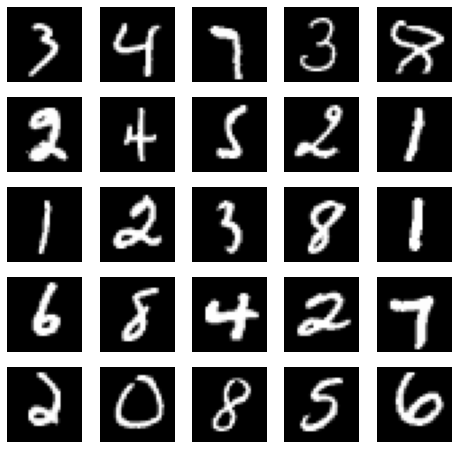

In [ ]:
#Visualização das imagens

def visualize_mnist_images_flat(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    #inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot

        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        # plot raw pixel data
        plt.imshow(inputs[i][0], cmap='gray')
    # show the figure
    plt.show()

visualize_mnist_images_flat(test_dl)

## 2. Definir o Modelo.

In [ ]:
import models_mnist #modulo python com os modelos       

model = models_mnist.VAE_MLP(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
# ler o modelo
SAVED_MODEL = 'VAE_MLP_MNIST.pth'
model= torch.load(SAVED_MODEL)
model.eval()
#visualizar a rede
print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0)) #verbose=2 Show weight and bias layers in full detail
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [128, 512]                401,920
├─Linear: 1-2                            [128, 256]                131,328
├─Linear: 1-3                            [128, 2]                  514
├─Linear: 1-4                            [128, 2]                  514
├─Linear: 1-5                            [128, 256]                768
├─Linear: 1-6                            [128, 512]                131,584
├─Linear: 1-7                            [128, 784]                402,192
Total params: 1,068,820
Trainable params: 1,068,820
Non-trainable params: 0
Total mult-adds (M): 136.51
Input size (MB): 0.40
Forward/backward pass size (MB): 2.38
Params size (MB): 4.28
Estimated Total Size (MB): 7.06


VAE_MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

## 4. Usar o Autoencoder.

torch.Size([128, 1, 28, 28])
outputs.shape:torch.Size([128, 784])
ls.shape:torch.Size([128, 2])
outputs.shape:torch.Size([128, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


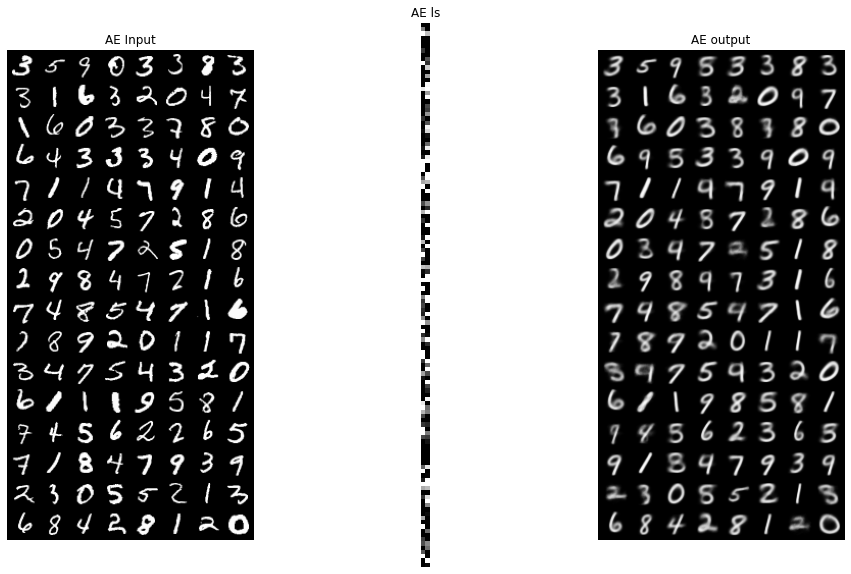

In [ ]:
def visualize(input_imgs, ls, output_imgs):
    input_imgs=input_imgs.permute((1, 2, 0))
    output_imgs=output_imgs.permute((1, 2, 0))
    ls=ls.permute((1, 2, 0))
    plt.subplots(1,3, figsize=(15, 10))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('AE Input')
    plt.imshow(input_imgs, cmap='gray')
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('AE ls')
    plt.imshow(ls.detach().numpy() , cmap='gray')
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('AE output')
    plt.imshow(output_imgs, cmap='gray')
    plt.show()

def test_image_reconstruction(model, test_dl):
    for batch in test_dl:
        img, _ = batch
        img = img.to(device)
        #img = img.view(img.size(0), -1)
        print(img.shape)
        outputs, ls,_,_ = model(img)
        print(f'outputs.shape:{outputs.shape}')
        print(f'ls.shape:{ls.shape}')
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        print(f'outputs.shape:{outputs.shape}')
        inputs = img.view(outputs.size(0), 1, 28, 28).cpu().data
        outputs = make_grid(outputs)
        inputs = make_grid(inputs)
        ls = make_grid(ls.cpu())
        break 
    return inputs, outputs, ls

inputs, outputs, ls = test_image_reconstruction(model, test_dl)
visualize(inputs, ls, outputs)

torch.Size([128, 1, 28, 28])
torch.float32
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


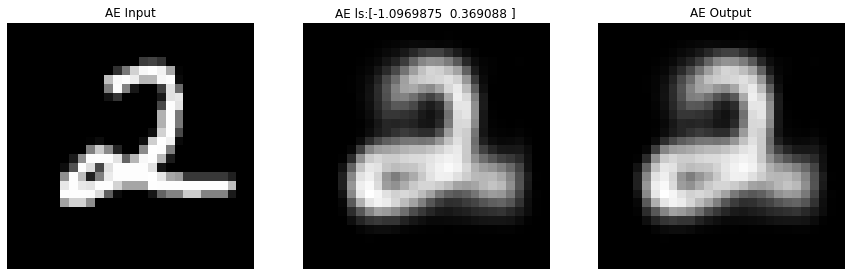

In [ ]:
# fazer uma previsão utilizando um caso

def make_prediction(model, img_list, idx): #img shape (784,1)

    print(img_list.shape)
    print(img_list.dtype) 
    img_list = img_list.to(device)
    prediction, ls,_,_ = model(img_list)
    print(prediction.shape)
    prediction = prediction.view(prediction.size(0), 1, 28, 28).cpu().data
    print(prediction.shape)
    img = img_list[idx].reshape(1,28, 28).cpu() #shape (1,1,28,28)
    plt.subplots(1,3, figsize=(15, 10))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('AE Input')
    plt.imshow(img.permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.title(f'AE ls:{ls.cpu().detach().numpy()[idx]}')
    plt.imshow(prediction[idx].permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('AE Output')
    plt.imshow(prediction[idx].permute((1, 2, 0)), cmap='gray')
    plt.show()
    
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10)

inputs.shape:torch.Size([10000, 1, 28, 28])
labes.shape:torch.Size([10000])
outputs.shape:torch.Size([10000, 784])
ls.shape:torch.Size([10000, 2])
ls min0:0.9477353692054749
ls max0:1.4665658473968506
ls min1:-0.72481769323349
ls max1:0.3507384657859802


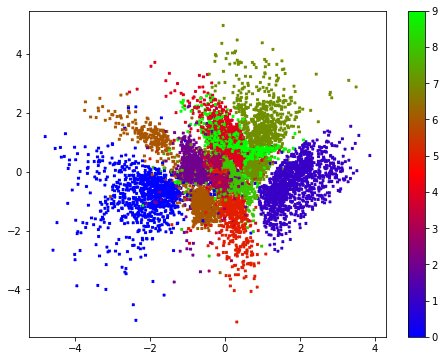

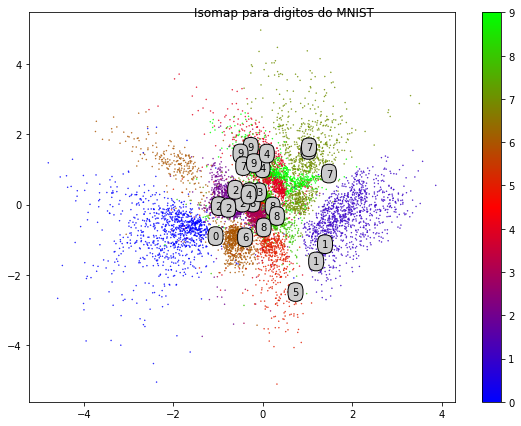

In [ ]:
def plot_t_test(t_test,y_test):
    # grafico do latent vector t_test colorido pelos valores dos digitos nas imagens de input
    plt.figure(figsize=(8, 6))
    plt.scatter(t_test[:, 0], t_test[:, 1], marker='x', s=6.0, c=y_test,  cmap='brg')
    plt.colorbar();
    plt.show()

def plot2_t_test(t_test,y_test):   
    plt.figure(figsize=(8, 6))
    plt.scatter(t_test[:, 0], t_test[:, 1],s=0.2, c=y_test, cmap='brg')
    plt.colorbar();
    #plt.set_xticks(())
    #plt.set_yticks(())
    count=0;
    plt.tight_layout()
    plt.suptitle("Isomap para digitos do MNIST")
    for label , x, y in zip(y_test, t_test[:, 0], t_test[:, 1]):
    #anotar na imagem cada 1 em 300 amostras
      if count % 400 == 0:
        plt.annotate(str(int(label)),xy=(x,y), color='black', weight='normal',size=10,bbox=dict(boxstyle="round4,pad=.5", fc="0.8"))
      count = count + 1
    #plt.savefig("mnist_pca.png")
    plt.show()
    
def test_image_clustering(model, test_dl):
    for batch in test_dl:
        img, labels = batch
        img = img.to(device)
        #img = img.view(img.size(0), -1)
        print(f'inputs.shape:{img.shape}')
        print(f'labes.shape:{labels.shape}')
        outputs, ls,_,_ = model(img)
        print(f'outputs.shape:{outputs.shape}')
        print(f'ls.shape:{ls.shape}')
        break #só quero um batch
    ls= ls.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return ls, labels

ls, labels = test_image_clustering(model, test_dl_all)
print(f'ls min0:{np.min(ls[0])}')
print(f'ls max0:{np.max(ls[0])}')
print(f'ls min1:{np.min(ls[1])}')
print(f'ls max1:{np.max(ls[1])}')
plot_t_test(ls,labels)
plot2_t_test(ls,labels)

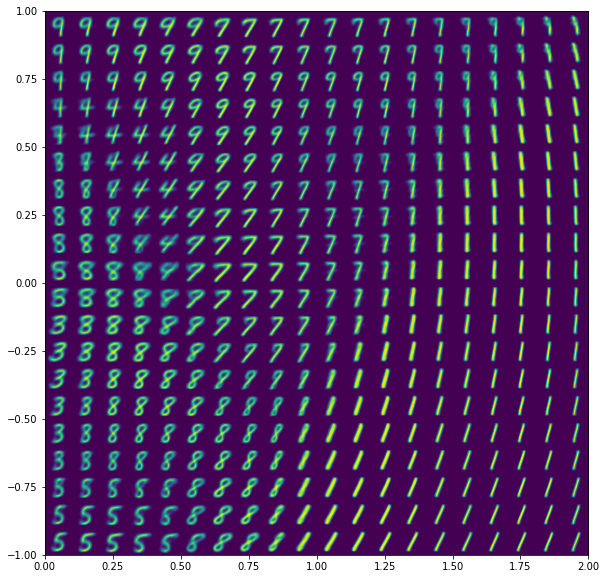

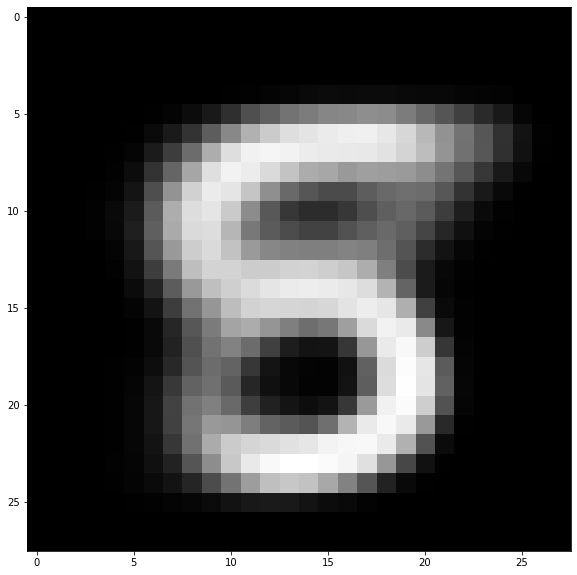

In [ ]:
def generate_images(model, r0=(-5, 10), r1=(-10, 5), n=20):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.figure(figsize=(10, 10))
    plt.imshow(img, extent=[*r0, *r1])
    
def generate_digit(x,y):   
    digit_size = 28
    figure = np.zeros((digit_size, digit_size)) #matriz para n=15*28 por n=15*28
    z = torch.Tensor([[x, y]]).to(device)
    t_decoded = model.decoder(z)
    digit = t_decoded[0].reshape(digit_size, digit_size).cpu().detach().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(digit, cmap='Greys_r');    
#ls min0:-4.231988430023193
#ls max0:2.2511589527130127
#ls min1:3.5808870792388916
#ls max1:36.23655700683594  
generate_images(model,(0,2),(-1,1))
generate_digit(0,0)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
tensor([[2.0271, 0.5514]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-4.1920, -1.0785]], device='cuda:0', grad_fn=<AddmmBackward>)


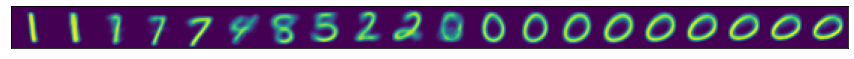

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    x_1 = x_1.view(1, 784)
    x_2 = x_2.view(1, 784)
    z_1,_ = autoencoder.encoder(x_1)
    z_2,_ = autoencoder.encoder(x_2)
    print(z_1)
    print(z_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()
    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def transicao(model, de, para):
    _, (inputs, targets) = next(enumerate(test_dl))
    inputs_1 = inputs[targets == de][1].to(device) # buscar o 1
    inputs_2 = inputs[targets == para][1].to(device) # find a 0
    print(inputs_1.shape)
    print(inputs_2.shape)
    interpolate(model, inputs_1, inputs_2, n=20)

transicao(model, 1, 0)

In [ ]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    x_1 = x_1.view(1, 784)
    x_2 = x_2.view(1, 784)
    z_1,_ = autoencoder.encoder(x_1)
    z_2,_ = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    images_list[0].save(filename,save_all=True,append_images=images_list[1:],loop=1)

def transicao_animada(model, de, para):
    _, (inputs, targets) = next(enumerate(test_dl))
    inputs_1 = inputs[targets == de][1].to(device) # buscar o 1
    inputs_2 = inputs[targets == para][1].to(device) # find a 0
    print(inputs_1.shape)
    print(inputs_2.shape)
    interpolate_gif(model, "VAE_transicao_animada.gif", inputs_1, inputs_2)

transicao_animada(model, 1, 0)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
